In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from dagger.graph import DAG, _calc_prior_discrete, _nodes_to_handle, _group_probs
from dagger.common import make_fake_df

In [3]:
df = pd.DataFrame({"a": [1,0,1,0,1], "b": [1,1,1,0,0], "c":[0,0,1,0,1] })

In [4]:
dag = DAG(df).add_edge("a", "b").add_edge("b", "c").add_edge("a", "c")

In [5]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 0, 0, 1], 
                   "c": [0, 0, 1, 0, 0, 1, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("c", "b").add_edge("a", "c")

In [6]:
dag.graph.edges

OutEdgeView([('a', 'b'), ('a', 'c'), ('c', 'b')])

In [7]:
def get_root_nodes(dag, nodes):
    graph = dag.graph.copy() 
    for node in nodes: 
        graph.remove_node(node)
    return tuple(x for x in graph.nodes() if graph.in_degree(x) == 0)

def get_leaf_nodes(dag, nodes):
    graph = dag.graph.copy()
    for node in nodes: 
        graph.remove_node(node)
    return tuple(x for x in graph.nodes() if graph.out_degree(x) == 0)

def normalise(x):
    return x/x.sum()

def merge_probs(frame1, frame2, col):
    return (frame1
             .set_index(col)
             .join(frame2.set_index(col), lsuffix="1", rsuffix="2")
             .assign(p = lambda x: normalise(x.p1 * x.p2))
             .drop("p1", axis=1)
             .drop("p2", axis=1)
             .reset_index())

In [8]:
nodes_done = set()
distributions = {}
nodes_to_do = set(dag._priors.keys())
prior_copy = dag._priors.copy()
while nodes_done != set(dag.graph.nodes):
    current_root_nodes = get_root_nodes(dag, nodes_done)
    for node in current_root_nodes:
        parents = list(dag.graph.predecessors(node))
        prob_df = (df
                   .assign(n=1)
                   .groupby(parents + [node])
                   .count()['n']
                   .reset_index()
                   .assign(p=lambda d: d.n/d.n.sum()))
        if len(parents) != 0:
            prob_df = prob_df.pipe(_group_probs, parents=parents)
        else:
            prob_df = prob_df.drop(columns=["n"])
        distributions[node] = prob_df
        nodes_done.add(node)

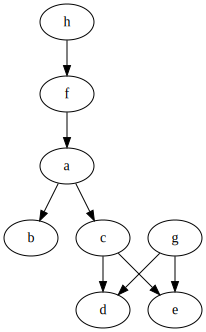

In [9]:
dag = (DAG(make_fake_df(8))
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("c", "d")
       .add_edge("c", "e")
       .add_edge("g", "e")
       .add_edge("g", "d")
       .add_edge("h", "f")
       .add_edge("f", "a"))

dag.plot()

In [10]:
dag.independences()

(c __||__ b) | a


In [10]:
# nodes_done = set()

# current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
# model_df = distributions[current_leaf_nodes[0]]
# while nodes_done != set(dag.graph.nodes):
#     current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
#     for node in current_leaf_nodes:
#         parents = list(dag.graph.predecessors(node))
#         for p in parents:
#             print(f"node={node}, parents={parents}, parent={p}")
#             print(model_df)
#             print(distributions[p])
#             model_df = merge_probs(model_df, distributions[p], p)
#             print(model_df)
#             if len(list(dag.graph.predecessors(p))) == 0:
#                 nodes_done.add(p)
#         nodes_done.add(node)

# model_df

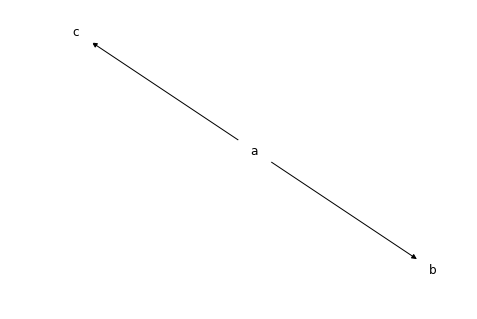

In [11]:
dag.nx_plot(node_size=1500, with_labels=True, node_color="white")

In [12]:
list(dag.parents("a")), list(dag.parents("b")), list(dag.parents("c"))

([], ['a'], ['a'])